In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SLCP experiment

In [4]:
from simulators import SLCP
from datasets import LTEDataset
from models import Flatten, MLP, NRE
from criterions import RELoss
from samplers import TractableSampler, NRESampler
from histograms import reduce_histogramdd, normalize, pairify, corner

## Simulator 

In [5]:
simulator = SLCP().to(device)
simulator.sample()

(tensor([-0.2744,  0.7638, -0.6783, -0.2245, -1.2385], device='cuda:0'),
 tensor([[-0.4901,  0.7919],
         [-0.6835,  0.8197],
         [-0.5973,  0.7415],
         [-0.5748,  0.8124]], device='cuda:0'))

In [6]:
trainset = LTEDataset(simulator)

## Model

In [7]:
encoder = Flatten((4, 2)).to(device)
model = NRE(5, 8, num_layers=10, hidden_size=512, activation=nn.SELU).to(device)
criterion = RELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=1e-1, patience=5, threshold=1e-2, verbose=True)

### Train

In [ ]:
model.train()

epoch = 0
epoch_size = 256

losses = []

for thetas, xs, mask in trainset:
    ratios = model(thetas, encoder(xs))
    loss = criterion(ratios, mask)

    losses.append(loss.tolist())

    optimizer.zero_grad()
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    optimizer.step()

    if len(losses) == epoch_size:
        losses = torch.tensor(losses)

        print(f'{epoch}: {losses.mean()} +- {losses.std()}')
        scheduler.step(losses.mean())

        epoch += 1
        losses = []

        if optimizer.param_groups[0]['lr'] < 1e-6:
            break

torch.save(model.state_dict(), 'nre.pth')

In [8]:
model.load_state_dict(torch.load('nre.pth', map_location=device))

<All keys matched successfully>

## Metropolis-Hastings

In [9]:
low = simulator.low.cpu()
high = simulator.high.cpu()

In [10]:
theta_star = torch.tensor([0.7, -2.9, -1., -0.9,  0.6]).to(device)
x_star = torch.tensor([
    [-0.48406151, -3.13977371],
    [-0.43098274, -3.50238278],
    [-0.03512463, -2.87554796],
    [ 1.43279532, -2.80650507]
]).to(device)

### Likelihood

In [11]:
sampler = TractableSampler(simulator, x_star, batch_size=2 ** 12, sigma=0.1)
samples = sampler(2 ** 6, 2 ** 14, groupby=2 ** 8)
hist_lhd = reduce_histogramdd(samples, 100, low, high, bounded=True, sparse=True, device='cpu')
hist_lhd = normalize(hist_lhd)

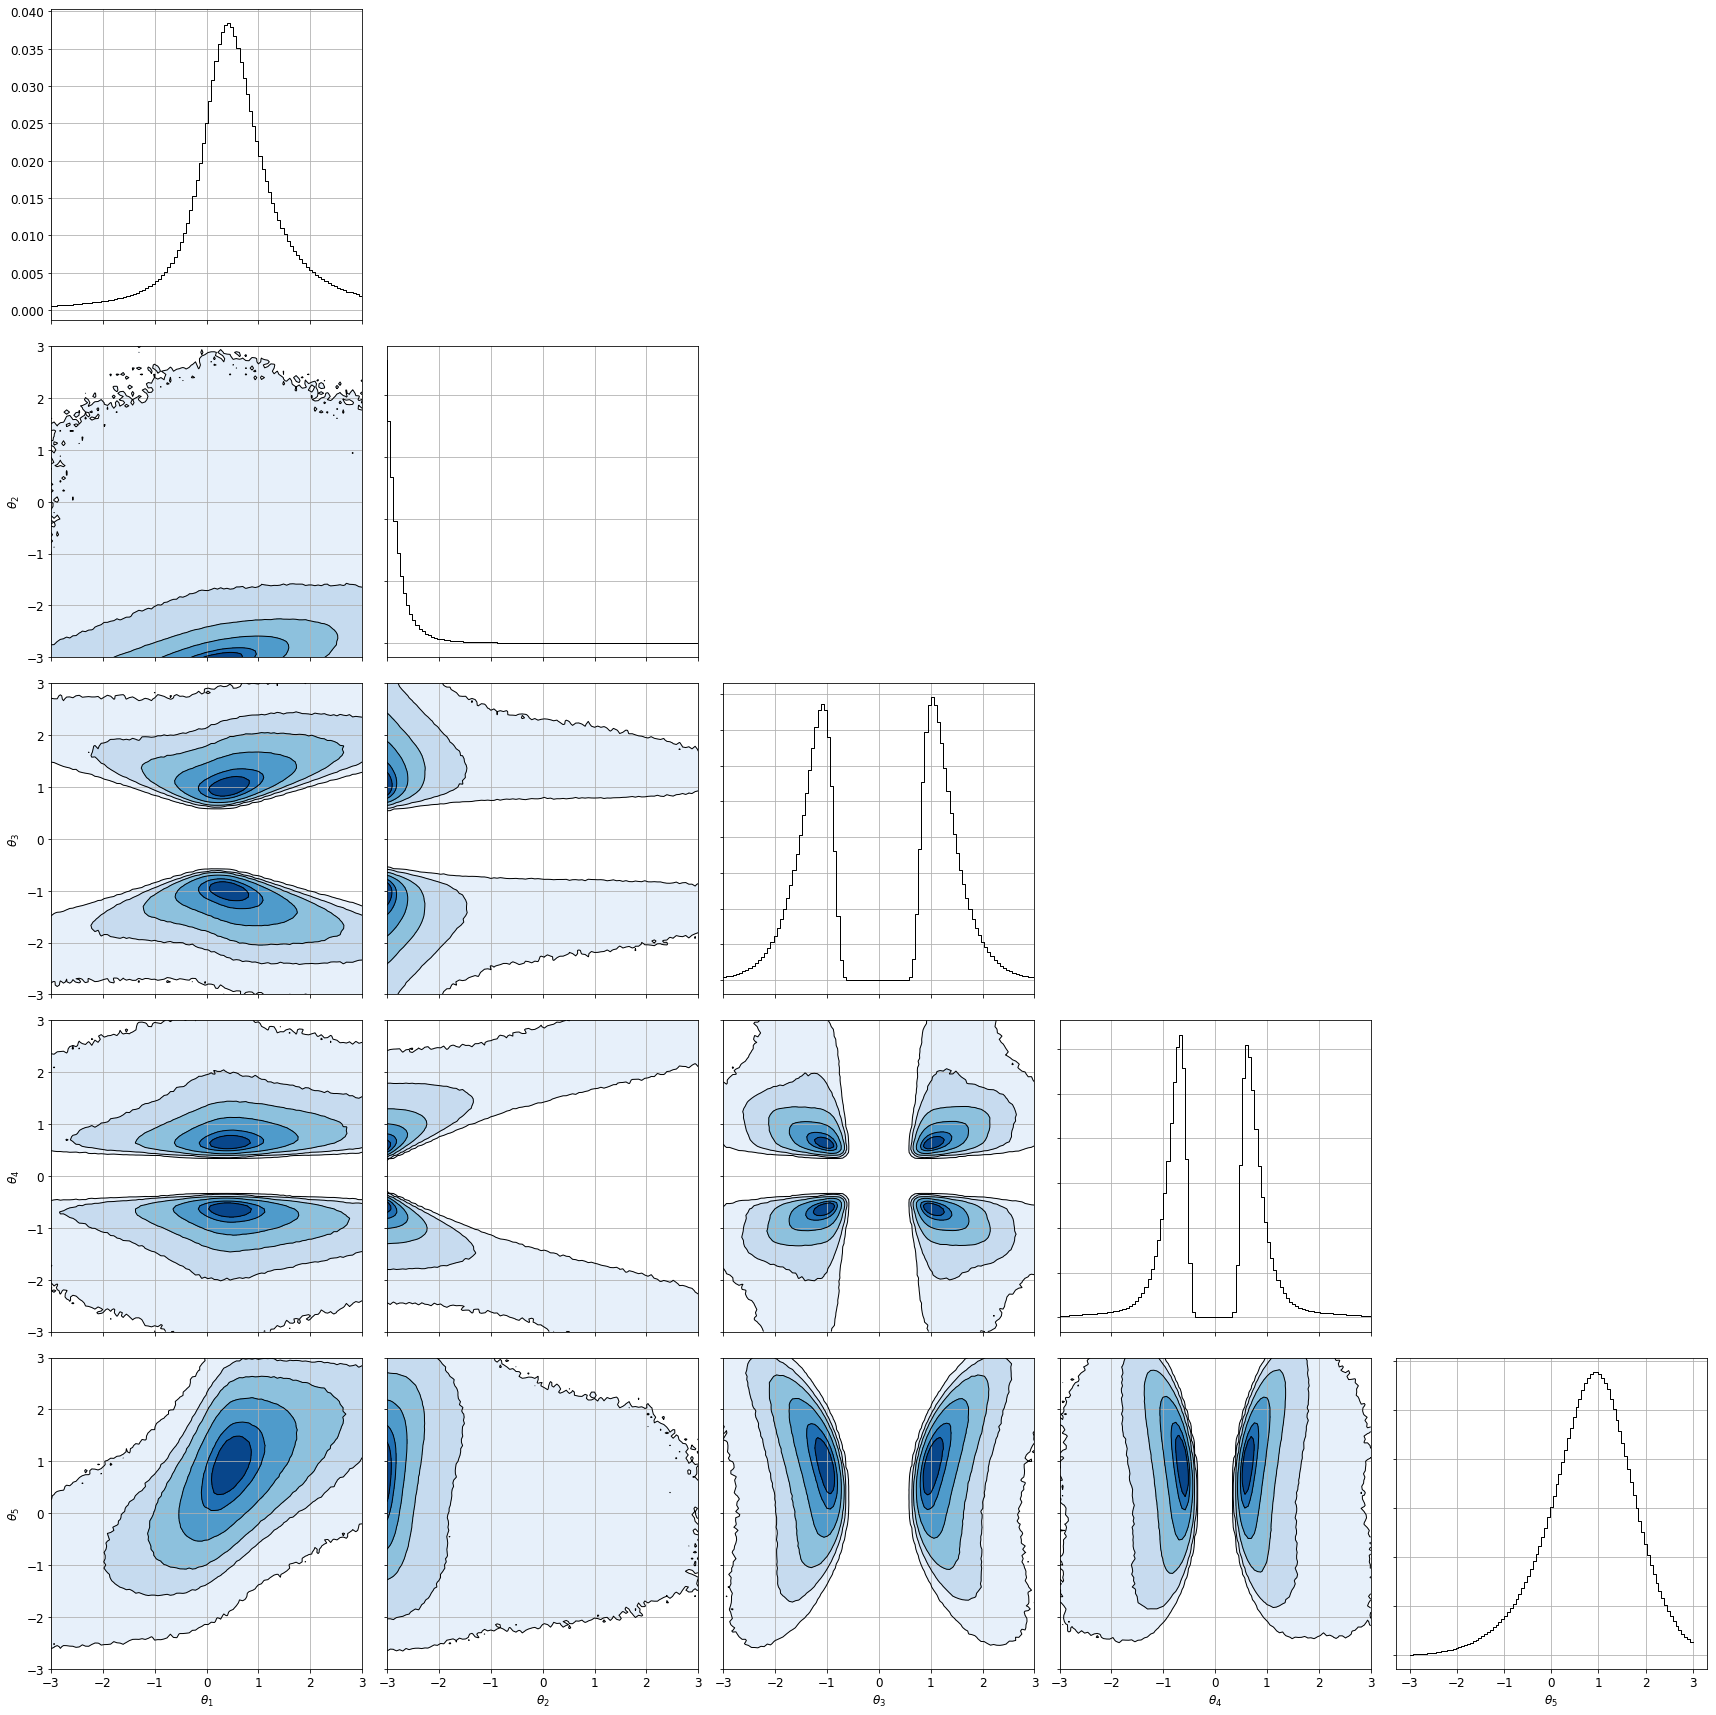

In [12]:
labels = [f'$\\theta_{{{i}}}$' for i in [1, 2, 3, 4, 5]]

hists = pairify(hist_lhd)
fig = corner(hists, low, high, labels=labels)

### NRE

In [13]:
model.eval()
z_star = encoder(x_star)

In [14]:
sampler = NRESampler(model, simulator.prior, z_star, batch_size=2 ** 12, sigma=0.1)
samples = sampler(2 ** 6, 2 ** 14, groupby=2 ** 8)
hist_nre = reduce_histogramdd(samples, 100, low, high, bounded=True, sparse=True, device='cpu')
hist_nre = normalize(hist_nre)

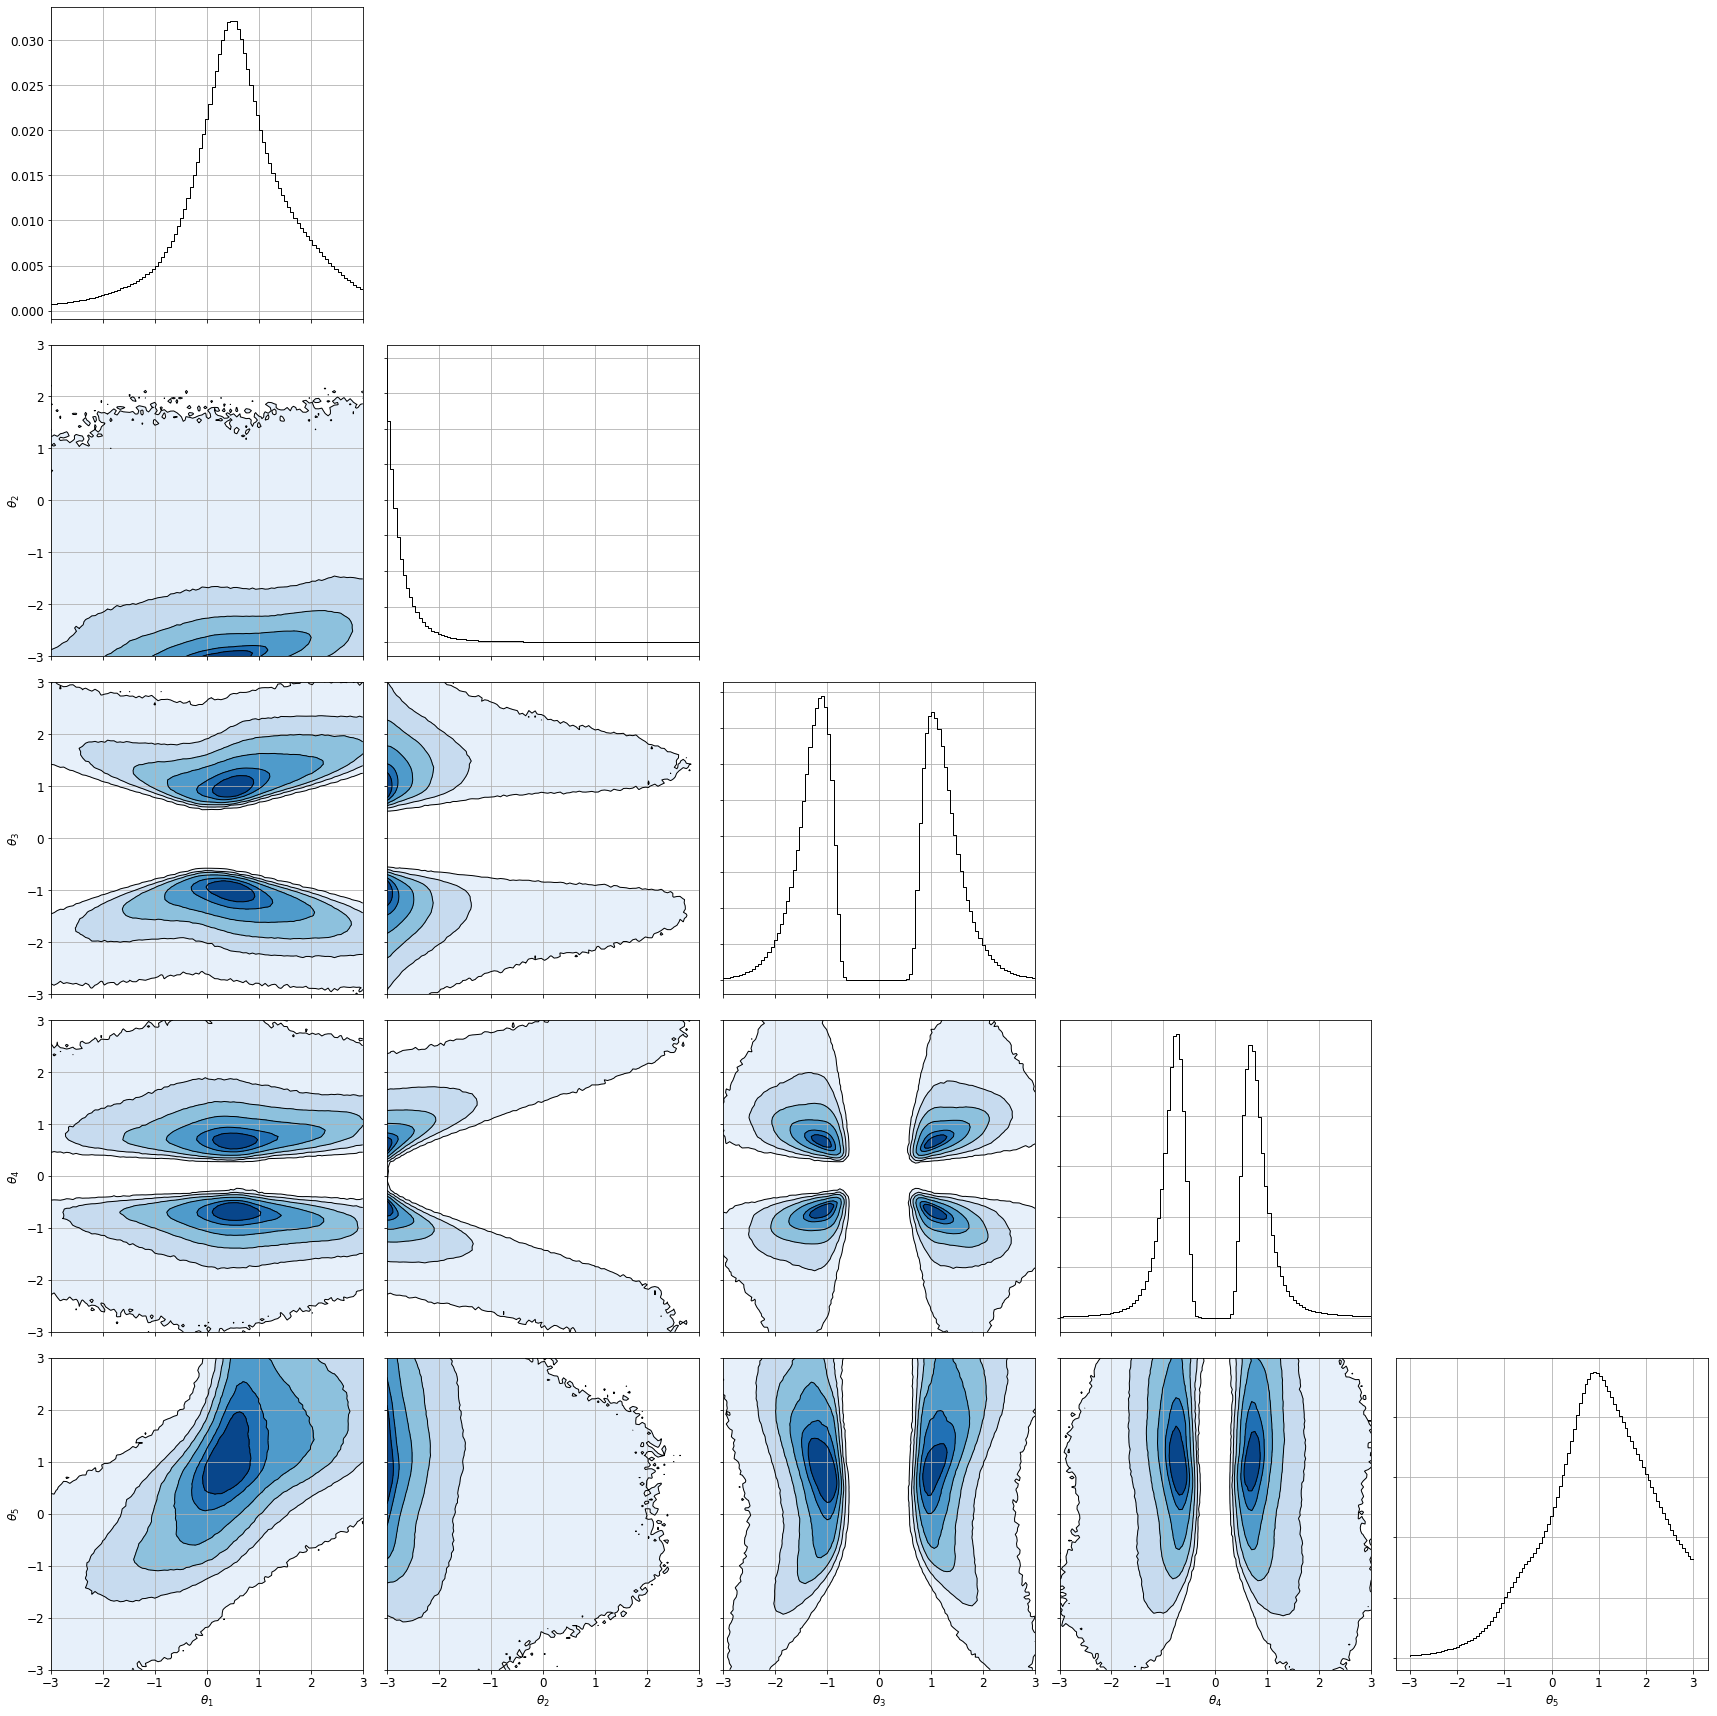

In [15]:
hists = pairify(hist_nre)
fig = corner(hists, low, high, labels=labels)